# Creating artificial clustered trajectories

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
np.random.seed(5432)

## Functions to build trajectories

Here's a few functions that we can use to create and morph trajectories.

In [3]:
def create_smooth_traj(number_steps=100, smooth_length=11):
    window = np.hanning(smooth_length)
    window /= window.sum()
    return pd.DataFrame({
        "x": np.convolve(
            np.random.normal(size=(number_steps, )),
            window,
            mode="valid",
        ).cumsum(),
        "y": np.convolve(
            np.random.normal(size=(number_steps, )),
            window,
            mode="valid",
        ).cumsum(),
    }).iloc[:number_steps]

In [4]:
def create_traj_from_to(
    start_x=0, 
    start_y=0, 
    end_x=1, 
    end_y=1, 
    number_steps=100,
):
    return pd.DataFrame({
        "x": np.linspace(start_x, end_x, number_steps),
        "y": np.linspace(start_y, end_y, number_steps),
    })

## Morphing in along-trajectory coordinate system

In [5]:
def get_local_coord_system(traj):
    
    # forward and backward (incoming diff)
    fwd = - traj.diff(periods=-1).add_prefix("d")
    bwd = traj.diff(periods=1).add_prefix("d")

    # symmetric direction
    # Note how we don't normalise before addition. Hence, larger steps have
    # a stronger influence on the symmetric direction of the trajectory.
    symm = fwd.add(bwd, axis=1) # / 2
    symm = symm.where(~symm.isnull(), fwd.fillna(0).add(bwd.fillna(0), axis=0))

    # normalize along-track directions
    symm = symm.div(symm.apply(lambda row: sum(row ** 2) ** 0.5, axis=1), axis=0)

    # rename
    symm = symm.rename(columns={"dx": "e1x", "dy": "e1y"})

    # add cross-track vector
    symm["e2x"] = symm["e1y"]
    symm["e2y"] = - symm["e1x"]

    return symm

## Create and morph a variable trajectory

In [6]:
traj = create_smooth_traj(number_steps=12, smooth_length=6)

In [7]:
directions = get_local_coord_system(traj)
directions

,e1x,e1y,e2x,e2y
0,0.021761,0.999763,0.999763,-0.021761
1,0.523531,0.852007,0.852007,-0.523531
2,0.842897,0.538075,0.538075,-0.842897
3,0.013839,0.999904,0.999904,-0.013839
4,-0.285482,0.958384,0.958384,0.285482
5,-0.139589,0.990209,0.990209,0.139589
6,0.071691,0.997427,0.997427,-0.071691


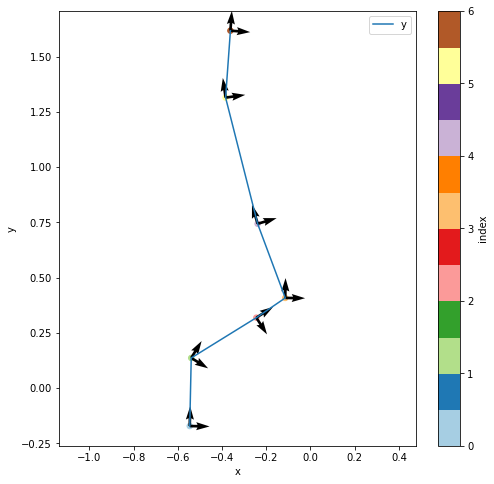

In [8]:
ax = traj.plot.line(x="x", y="y", figsize=(8, 8))
traj.reset_index().plot.scatter(
    x="x", y="y", marker="o", s=30, c="index", cmap="Paired", ax=ax
);
ax.quiver(traj["x"], traj["y"], directions["e1x"], directions["e1y"])
ax.quiver(traj["x"], traj["y"], directions["e2x"], directions["e2y"])
ax.axis('equal');

In [9]:
morphs = pd.DataFrame({
    "d1": 0.05 * np.random.normal(size=(len(traj), )),
    "d2": 0.05 * np.random.normal(size=(len(traj), )),
})
morphs

,d1,d2
0,-0.011261,0.039031
1,0.005176,-0.031492
2,-0.074283,0.005405
3,-0.074406,0.041868
4,-0.047699,-0.012062
5,-0.052900,-0.016776
6,-0.025061,-0.041588


In [10]:
m1 = directions.filter(like="e1").mul(morphs["d1"], axis=0)
m2 = directions.filter(like="e2").mul(morphs["d2"], axis=0)
m = m1 + m2.to_numpy()
m

,e1x,e1y
0,0.038777,-0.012108
1,-0.024122,0.020898
2,-0.059704,-0.044526
3,0.040834,-0.074978
4,0.002057,-0.049157
5,-0.009227,-0.054724
6,-0.043278,-0.022015


In [11]:
traj_morphed = traj + m.to_numpy()

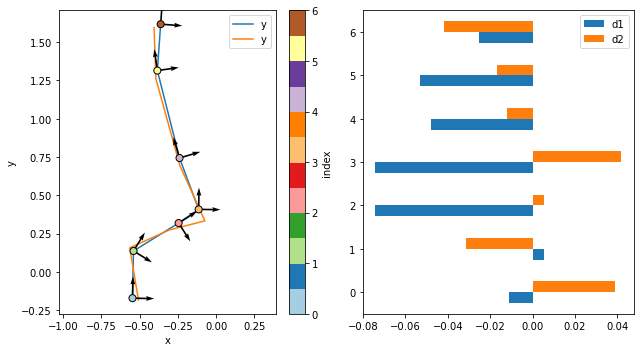

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(9, 5))

traj.plot.line(x="x", y="y", ax=ax[0])
traj.reset_index().plot.scatter(
    x="x", y="y", marker="o",
    s=50, c="index", cmap="Paired",
    edgecolor="k",
    zorder=100,
    ax=ax[0],
);
ax[0].quiver(traj["x"], traj["y"], directions["e1x"], directions["e1y"], scale=10, zorder=99)
ax[0].quiver(traj["x"], traj["y"], directions["e2x"], directions["e2y"], scale=10, zorder=99)
traj_morphed.plot.line(
    x="x", y="y", ax=ax[0]
);
ax[0].axis('equal');

morphs.plot.barh(ax=ax[1])

fig.tight_layout();

## Create and morph a straight trajectory

In [13]:
traj = create_traj_from_to(number_steps=12)

In [14]:
directions = get_local_coord_system(traj)
directions

,e1x,e1y,e2x,e2y
0,0.707107,0.707107,0.707107,-0.707107
1,0.707107,0.707107,0.707107,-0.707107
2,0.707107,0.707107,0.707107,-0.707107
3,0.707107,0.707107,0.707107,-0.707107
4,0.707107,0.707107,0.707107,-0.707107
5,0.707107,0.707107,0.707107,-0.707107
6,0.707107,0.707107,0.707107,-0.707107
7,0.707107,0.707107,0.707107,-0.707107
8,0.707107,0.707107,0.707107,-0.707107
9,0.707107,0.707107,0.707107,-0.707107


In [15]:
morphs = pd.DataFrame({
    "d1": 0.05 * np.random.normal(size=(len(traj), )),
    "d2": 0.05 * np.random.normal(size=(len(traj), )),
})
morphs

,d1,d2
0,-0.033349,0.008792
1,0.039261,-0.023600
2,-0.042721,-0.026114
3,0.043230,-0.005119
4,0.044662,-0.009548
5,0.005921,-0.106776
6,0.060744,-0.049716
7,0.141513,-0.075160
8,-0.017326,-0.006756
9,0.023243,0.049922


In [16]:
m1 = directions.filter(like="e1").mul(morphs["d1"], axis=0)
m2 = directions.filter(like="e2").mul(morphs["d2"], axis=0)
m = m1 + m2.to_numpy()
m

,e1x,e1y
0,-0.017364,-0.029799
1,0.011074,0.044450
2,-0.048674,-0.011743
3,0.026948,0.034188
4,0.024829,0.038332
5,-0.071316,0.079689
6,0.007798,0.078107
7,0.046918,0.153211
8,-0.017029,-0.007474
9,0.051735,-0.018865


In [17]:
traj_morphed = traj + m.to_numpy()

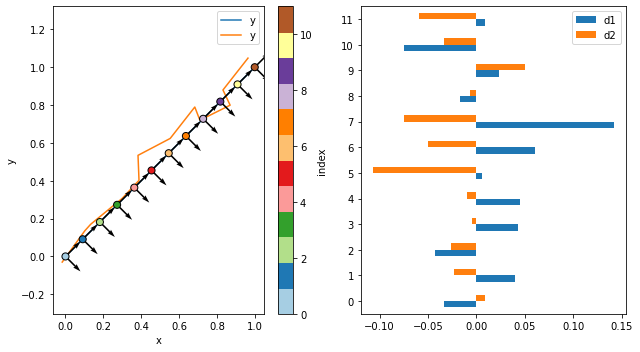

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(9, 5))

traj.plot.line(x="x", y="y", ax=ax[0])
traj.reset_index().plot.scatter(
    x="x", y="y", marker="o",
    s=50, c="index", cmap="Paired",
    edgecolor="k",
    zorder=100,
    ax=ax[0],
);
ax[0].quiver(traj["x"], traj["y"], directions["e1x"], directions["e1y"], scale=10, zorder=99)
ax[0].quiver(traj["x"], traj["y"], directions["e2x"], directions["e2y"], scale=10, zorder=99)
traj_morphed.plot.line(
    x="x", y="y", ax=ax[0]
);
ax[0].axis('equal');

morphs.plot.barh(ax=ax[1])

fig.tight_layout();